In [1]:
import chess.pgn
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def pgn_generator(f):
    while game := chess.pgn.read_game(f):
        yield game

In [3]:
def is_rated(game):
    return game.headers['Event'].startswith('Rated')

def is_computer(game):
    return game.headers['White'].startswith('lichess AI') or game.headers['Black'].startswith('lichess AI')

In [4]:
with open('../data/lichess_dbz10_2022-07-18.pgn','r') as f:
    games = [
        game for game in pgn_generator(f) 
        # if is_rated(game)
        if not is_computer(game)
    ]

In [5]:
all_players = set(
    [game.headers['White'] for game in games]  + [game.headers['Black'] for game in games]
)

In [6]:
G = nx.Graph()

In [7]:
for player in all_players:
    G.add_node(player)

In [8]:
def build_graph(G,me):
    for game in games:
        color_played = 'White' if game.headers['White'] == me else 'Black'
        opponent_color = 'Black' if color_played == 'White' else 'White'
        u = me
        v = game.headers[opponent_color] 
        try:
            G[u][v]['weight'] += 1
            # G[u][v]['incoming_rating_diff'] += int(game.headers[f'{color_played}RatingDiff'])
            # G[u][v]['outgoing_rating_diff'] += int(game.headers[f'{opponent_color}RatingDiff'])
        except KeyError:
            G.add_edge(u,v, weight = 1)
            # G[u][v]['incoming_rating_diff'] = int(game.headers[f'{color_played}RatingDiff'])
            # G[u][v]['outgoing_rating_diff'] = int(game.headers[f'{opponent_color}RatingDiff'])
    return G

In [9]:
G = build_graph(G, me='dbz10')

Collapse everyone "else" into a single node.

In [10]:
def condense_graph(G, me):
    players_condensed = set(
        [e[0] for e in G.edges(data = 'weight') if e[2] > 1]
        + [e[1] for e in G.edges(data = 'weight') if e[2] > 1]
        + ['other']
    )

    edges_condensed = (
        [(e[0], e[1], e[2]) for e in G.edges(data = 'weight') if e[2] > 1]
        + [(me,'other',1)]
    )
    
    return {
        'players_condensed' : players_condensed,
        'edges_condensed' : edges_condensed
    }

In [11]:
res = condense_graph(G, 'dbz10')

In [12]:
C = nx.Graph()
C.add_weighted_edges_from(res['edges_condensed'])

In [13]:
pos = nx.spring_layout(C)

In [14]:
edgewidth = [np.sqrt(C.get_edge_data(u, v)['weight']) for u, v in C.edges()]


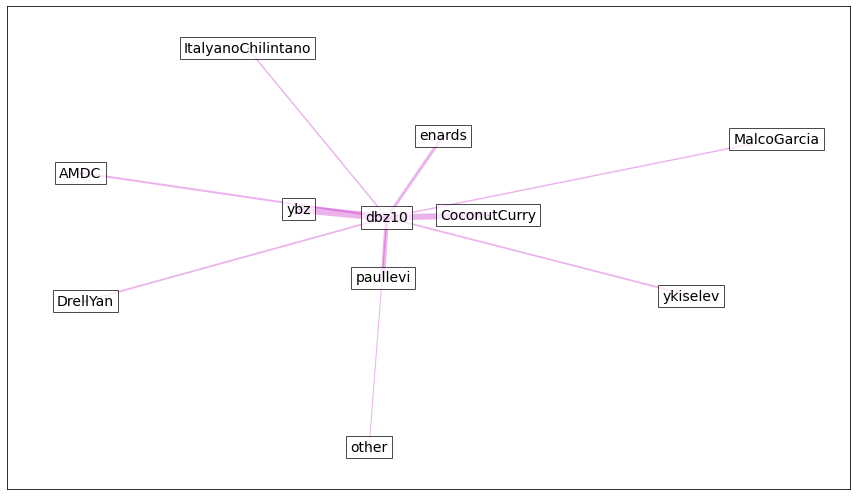

In [19]:
fig, ax = plt.subplots(figsize=(12,7))
# Visualize graph components
nx.draw_networkx_edges(C, pos, alpha=0.3, width = edgewidth, edge_color="m")
nx.draw_networkx_nodes(C, pos, node_size=1, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(C, pos, font_size=14, bbox=label_options)
plt.tight_layout()
plt.savefig('../assets/network.png')
plt.show()